# `Playing with new 2017 tf.contrib.seq2seq`

TF now has new `tf.contrib.seq2seq`. Let's make small example of using it.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, GRUCell
from model_new import Seq2SeqModel, train_on_copy_task
import pandas as pd
import helpers

import warnings
warnings.filterwarnings("ignore")

In [2]:
tf.__version__

'1.0.0'

By this point implementations are quite long, so I put them in [model_new.py](model_new.py), while notebook will illustrate the application.

In [3]:
tf.reset_default_graph()
tf.set_random_seed(1)

with tf.Session() as session:

    # with bidirectional encoder, decoder state size should be
    # 2x encoder state size
    model = Seq2SeqModel(encoder_cell=LSTMCell(10),
                         decoder_cell=LSTMCell(20), 
                         vocab_size=10,
                         embedding_size=10,
                         attention=True,
                         bidirectional=True,
                         debug=False)

    session.run(tf.global_variables_initializer())

    train_on_copy_task(session, model,
                       length_from=3, length_to=8,
                       vocab_lower=2, vocab_upper=10,
                       batch_size=100,
                       max_batches=3000,
                       batches_in_epoch=1000,
                       verbose=True)

batch 0
  minibatch loss: 2.2918014526367188
  sample 1:
    enc input           > [6 9 8 0 0 0 0 0]
    dec train predicted > [3 5 5 3 0 0 0 0 0]
  sample 2:
    enc input           > [8 2 9 8 0 0 0 0]
    dec train predicted > [4 2 2 2 2 0 0 0 0]
  sample 3:
    enc input           > [4 8 2 6 0 0 0 0]
    dec train predicted > [6 5 3 3 5 0 0 0 0]

batch 1000
  minibatch loss: 0.3415927588939667
  sample 1:
    enc input           > [4 2 6 9 4 9 0 0]
    dec train predicted > [4 2 6 9 4 9 1 0 0]
  sample 2:
    enc input           > [9 3 6 4 0 0 0 0]
    dec train predicted > [9 3 6 4 1 0 0 0 0]
  sample 3:
    enc input           > [8 8 3 9 0 0 0 0]
    dec train predicted > [8 8 3 9 1 0 0 0 0]

batch 2000
  minibatch loss: 0.09890518337488174
  sample 1:
    enc input           > [4 6 3 5 7 5 0 0]
    dec train predicted > [4 6 3 5 7 5 1 0 0]
  sample 2:
    enc input           > [7 3 7 8 0 0 0 0]
    dec train predicted > [7 3 7 8 1 0 0 0 0]
  sample 3:
    enc input           > [2

## Fun exercise, compare performance of different seq2seq variants.

Comparison will be done using train loss tracks, since the task is algorithmic and data is generated directly from true distribution and out-of-sample testing doesn't really make sense.

In [4]:
loss_tracks = dict()

def do_train(session, model):
    return train_on_copy_task(session, model,
                              length_from=3, length_to=8,
                              vocab_lower=2, vocab_upper=10,
                              batch_size=100,
                              max_batches=5000,
                              batches_in_epoch=1000,
                              verbose=False)

def make_model(**kwa):
    args = dict(cell_class=LSTMCell,
                num_units_encoder=10,
                vocab_size=10,
                embedding_size=10,
                attention=False,
                bidirectional=False,
                debug=False)
    args.update(kwa)
    
    cell_class = args.pop('cell_class')
    
    num_units_encoder = args.pop('num_units_encoder')
    num_units_decoder = num_units_encoder
    
    if args['bidirectional']:
        num_units_decoder *= 2
    
    args['encoder_cell'] = cell_class(num_units_encoder)
    args['decoder_cell'] = cell_class(num_units_decoder)
    
    return Seq2SeqModel(**args)

### Test bidirectional/forward encoder, attention/no attention, in all combinations

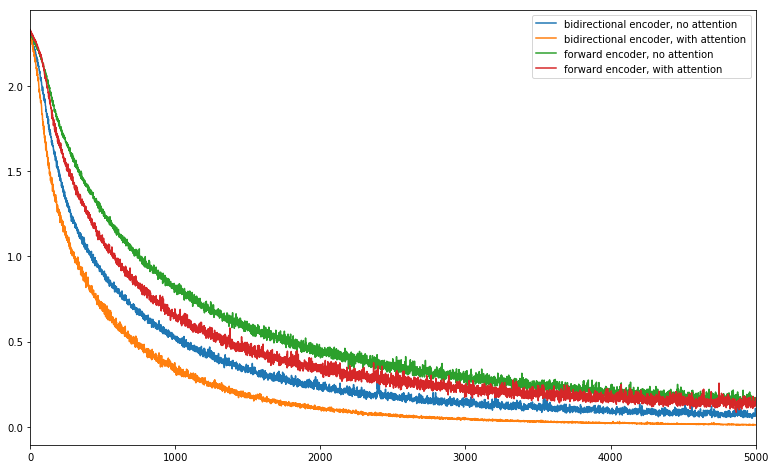

In [5]:
tf.reset_default_graph()
tf.set_random_seed(1)
with tf.Session() as session:
    model = make_model(bidirectional=False, attention=False)
    session.run(tf.global_variables_initializer())
    loss_tracks['forward encoder, no attention'] = do_train(session, model)


tf.reset_default_graph()
tf.set_random_seed(1)
with tf.Session() as session:
    model = make_model(bidirectional=True, attention=False)
    session.run(tf.global_variables_initializer())
    loss_tracks['bidirectional encoder, no attention'] = do_train(session, model)


tf.reset_default_graph()
tf.set_random_seed(1)
with tf.Session() as session:
    model = make_model(bidirectional=False, attention=True)
    session.run(tf.global_variables_initializer())
    loss_tracks['forward encoder, with attention'] = do_train(session, model)

    
tf.reset_default_graph()
tf.set_random_seed(1)
with tf.Session() as session:
    model = make_model(bidirectional=True, attention=True)
    session.run(tf.global_variables_initializer())
    loss_tracks['bidirectional encoder, with attention'] = do_train(session, model)

pd.DataFrame(loss_tracks).plot(figsize=(13, 8))

Naturally, attention helps a lot when the task is simply copying from inputs to outputs.

### Test GRU vs LSTM

In [6]:
import time

tf.reset_default_graph()
tf.set_random_seed(1)
with tf.Session() as session:
    model = make_model(bidirectional=True, attention=True, cell_class=LSTMCell)
    session.run(tf.global_variables_initializer())
    t0 = time.time()
    lstm_track = do_train(session, model)
    lstm_took = time.time() - t0

tf.reset_default_graph()
tf.set_random_seed(1)
with tf.Session() as session:
    model = make_model(bidirectional=True, attention=True, cell_class=GRUCell)
    session.run(tf.global_variables_initializer())
    t0 = time.time()
    gru_track = do_train(session, model)
    gru_took = time.time() - t0
    
gru = pd.Series(gru_track, name='gru')
lstm = pd.Series(lstm_track, name='lstm')
tracks_batch = pd.DataFrame(dict(lstm=lstm, gru=gru))
tracks_batch.index.name = 'batch'

gru.index = gru.index / gru_took
lstm.index = lstm.index / lstm_took
tracks_time = pd.DataFrame(dict(lstm=lstm, gru=gru)).ffill()
tracks_time.index.name = 'time (seconds)'

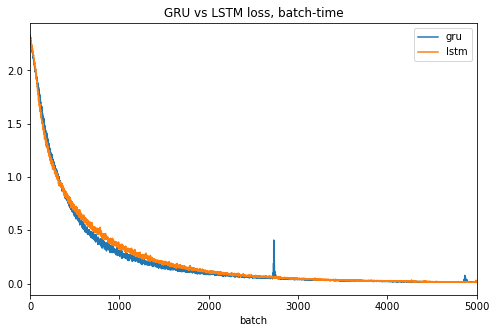

In [7]:
tracks_batch.plot(figsize=(8, 5), title='GRU vs LSTM loss, batch-time')

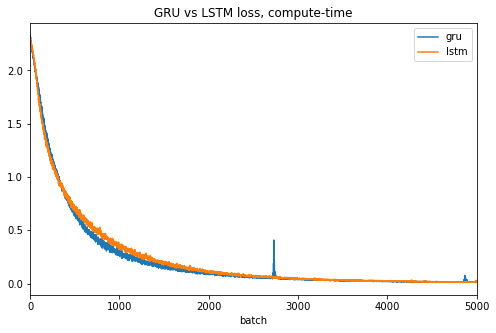

In [8]:
tracks_batch.plot(figsize=(8, 5), title='GRU vs LSTM loss, compute-time')

GRU has fewer parameters, so training supposed to be faster? This test doesn't show it.